In [1]:
from qiskit import  Aer, ClassicalRegister, QuantumRegister, QuantumCircuit, execute
# import basic plot tools
from qiskit.visualization import plot_histogram

def adder(bits):
    a = QuantumRegister(bits, name="first") #First number
    b = QuantumRegister(bits+1, name="second") #Second number, then sum
    c = QuantumRegister(bits, name="carry") #Carry bits

    #Combining all of them into one quantum circuit
    qc = QuantumCircuit(a, b, c)

    for i in range(bits-1):
        qc.ccx(a[i], b[i], c[i+1])
        qc.cx(a[i], b[i])
        qc.ccx(c[i], b[i], c[i+1])

    qc.ccx(a[bits-1], b[bits-1], b[bits])
    qc.cx(a[bits-1], b[bits-1])
    qc.ccx(c[bits-1], b[bits-1], b[bits])

    #Reversing the gate operation performed on b[n-1]
    qc.cx(c[bits-1], b[bits-1])
    #Reversing the gate operations performed during the carry gate implementations
    #This is done to ensure the sum gates are fed with the correct input bit states
    for i in range(bits-1):
        qc.ccx(c[(bits-2)-i], b[(bits-2)-i], c[(bits-1)-i])
        qc.cx(a[(bits-2)-i], b[(bits-2)-i])
        qc.ccx(a[(bits-2)-i], b[(bits-2)-i], c[(bits-1)-i])
        #These two operations act as a sum gate; if a control bit is at                
        #the 1> state then the target bit b[(n-2)-i] is flipped
        qc.cx(c[(bits-2)-i], b[(bits-2)-i])
        qc.cx(a[(bits-2)-i], b[(bits-2)-i])

    adderGate = qc.to_gate()
    adderGate.name = "Adder"
    return adderGate


In [2]:
def bitComparator():
    qc = QuantumCircuit(4)
    
    qc.x(1)

    qc.ccx(0,1,2)

    qc.x(0)
    qc.x(1)
    
    qc.ccx(0,1,3)

    qc.x(0)

    # We will return the diffuser as a gate
    U_c = qc.to_gate()
    U_c.name = "$U_c$"
    return U_c 

def comparer():
    b0 = QuantumRegister(4, name="bit0")
    z0_1 = QuantumRegister(1, name="zero 01")
    b1 = QuantumRegister(4, name="bit1")
    z1_2 = QuantumRegister(1, name="zero 12")
    b2 = QuantumRegister(4, name="bit2")

    qc = QuantumCircuit(b0, z0_1, b1, z1_2, b2)

    bc0 = bitComparator()
    bc1 = bitComparator()
    bc2 = bitComparator()
    qc.append(bc0, [0,1,2,3])
    qc.append(bc1, [5,6,7,8])
    qc.append(bc2, [10,11,12,13])

    qc.x(2)
    qc.x(3)
    qc.ccx(2,3,4)
    qc.x(2)
    qc.x(3)

    qc.x(7)
    qc.x(8)
    qc.ccx(7,8,9)
    qc.x(7)
    qc.x(8)
    qc.ccx(12,9,7)
    qc.ccx(13,9,8)

    qc.ccx(7,4,2)
    qc.ccx(8,4,3)

    comparerGate = qc.to_gate()
    comparerGate.name = "Comparer"
    return comparerGate



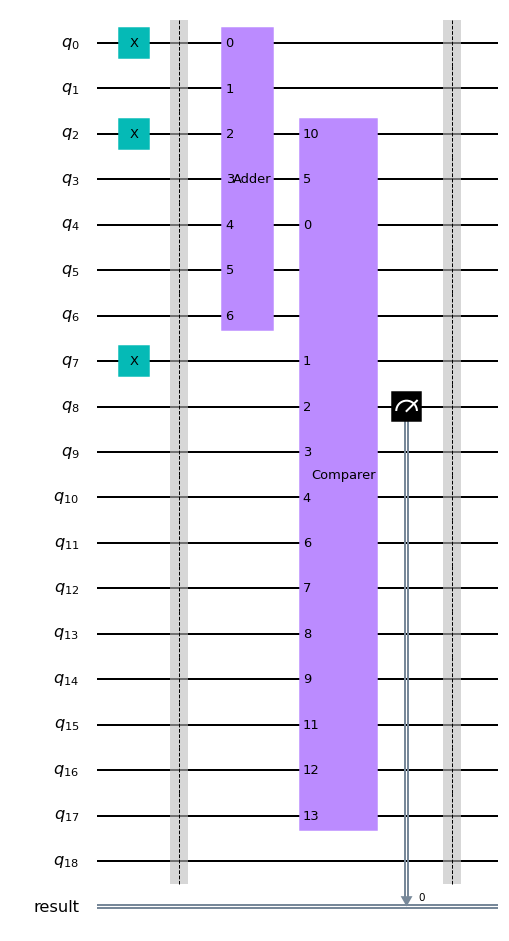

In [3]:
first = "01"
second = "01"

threshold = "100"


oracle = QuantumCircuit(19)


if first[0] == "1":
    oracle.x(1)
if first[1] == "1":
    oracle.x(0)

if second[0] == "1":
    oracle.x(3)
if second[1] == "1":
    oracle.x(2)

if threshold[0] == "1":
    oracle.x(7)
if threshold[1] == "1":
    oracle.x(11)
if threshold[2] == "1":
    oracle.x(15)


oracle.barrier()

oracle.append(adder(2), [0,1,2,3,4,5,6])
oracle.append(comparer(), [4,7,8,9,10,3,11,12,13,14,2,15,16,17])

r = ClassicalRegister(1, name="result") #Classical output
oracle.add_register(r)

oracle.measure([8], r)
oracle.barrier()

oracle.draw()

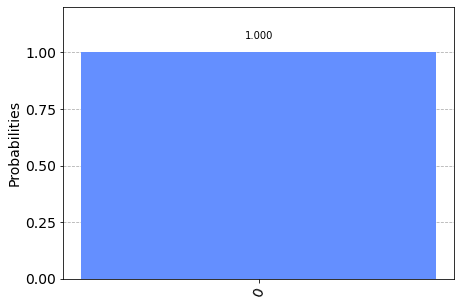

In [4]:
qasm_simulator = Aer.get_backend('qasm_simulator')
shots = 1024
results = execute(oracle, backend=qasm_simulator, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)